In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lmfit
import json


In [10]:
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)


In [11]:
all_fit_params = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/05_nmr_ntp_adduction/01.047.NMR_NTP_adduction_kinetics/data/peak_analysis/all_data_fitparams.csv'

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


lnkadd_atp20: -6.67644150677047 ± 0.15205076475404636
lnkadd_ctp20: -6.981798003237149 ± 0.3207245387227223
lnkadd_gtp20: -6.272974102461831 ± 0.43844928876100253


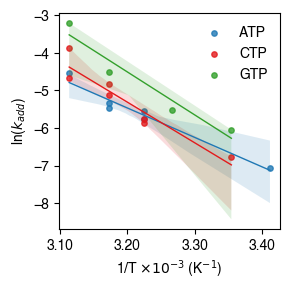

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))
formatter = FuncFormatter(thousands)

nmr_ntp = pd.read_csv(all_fit_params)
peak8 = nmr_ntp[nmr_ntp['peak'] == 'peak8']
peak8_atp = peak8[peak8['ntp'] == 'ATP']
sns.regplot(x='1/T', y='lnkadd', data=peak8_atp, ax = ax, label='ATP', scatter_kws={'s': 15}, line_kws={'linewidth': 1}, color = sns.color_palette("Paired")[1])

peak8_ctp = peak8[peak8['ntp'] == 'CTP']
sns.regplot(x='1/T', y='lnkadd', data=peak8_ctp, ax = ax, label='CTP', scatter_kws={'s': 15}, line_kws={'linewidth': 1}, color = sns.color_palette("Paired")[5])
peak8_gtp = peak8[peak8['ntp'] == 'GTP']
sns.regplot(x='1/T', y='lnkadd', data=peak8_gtp, ax = ax, label='GTP', scatter_kws={'s': 15}, line_kws={'linewidth': 1}, color = sns.color_palette("Paired")[3])

# Set the x-axis formatter
ax.xaxis.set_major_formatter(formatter)

ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.set_ylabel(r'ln($k_{add}$)')

plt.legend(frameon = False)
plt.tight_layout()
plt.savefig('nmr_ntp_adduction_eyringfit.pdf')

# linear fit
model = lmfit.models.LinearModel()
params = model.guess(peak8_atp['lnkadd'], x=peak8_atp['1/T'])
atp_result = model.fit(peak8_atp['lnkadd'], params, x=peak8_atp['1/T'])
lnkadd_atp20 = atp_result.eval(x = 1 / (298.15))
lnkadd_atp20_err = atp_result.eval_uncertainty(x = 1 / (298.15))

ctp_result = model.fit(peak8_ctp['lnkadd'], params, x=peak8_ctp['1/T'])
lnkadd_ctp20 = ctp_result.eval(x = 1 / (298.15))
lnkadd_ctp20_err = ctp_result.eval_uncertainty(x = 1 / (298.15))

print(f'lnkadd_atp20: {lnkadd_atp20} ± {lnkadd_atp20_err}')
print(f'lnkadd_ctp20: {lnkadd_ctp20} ± {lnkadd_ctp20_err}')

gtp_result = model.fit(peak8_gtp['lnkadd'], params, x=peak8_gtp['1/T'])
lnkadd_gtp20 = gtp_result.eval(x = 1 / (298.15))
lnkadd_gtp20_err = gtp_result.eval_uncertainty(x = 1 / (298.15))
print(f'lnkadd_gtp20: {lnkadd_gtp20} ± {lnkadd_gtp20_err}')

In [13]:
# extrapolate lnkdeg

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['lnkdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)

deg_model = lmfit.models.LinearModel()
params = deg_model.guess(df_kdeg['lnkdeg'], x=df_kdeg['inv_temp'])
deg_result = deg_model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])
lnkdeg20 = deg_result.eval(x = 1 / (298.15))

print(f'lnkdeg at 20°C: {lnkdeg20}')

lnkdeg at 20°C: -8.557912048292785


In [14]:
from scipy.integrate import solve_ivp

def simulate_fraction_modified(ntp_conc, lnkadd, lnkdeg, label, ax):

    RNACONC = ntp_conc
    DMSCONC = 0.01564

    # Initial conditions
    U0 = RNACONC
    S0 = DMSCONC
    M0 = 0.0
    y0 = [U0, S0, M0]

    # Convert log(k1) and log(k2) to k1 and k2
    k1 = np.exp(lnkadd)
    k2 = np.exp(lnkdeg)

    # Define ODE system
    def system(t, y):
        U, S, M = y
        dUdt = -k1 * U * S
        dSdt = -k1 * U * S - k2 * S
        dMdt = k1 * U * S
        return [dUdt, dSdt, dMdt]

    # Add 0 to the beginning if needed
    t = np.linspace(0, 20000, 1001)

    # Simulate the system
    sol = solve_ivp(system, [t[0], t[-1]], y0, t_eval=t, vectorized=True)

    U, S, M = sol.y
    frac_modified = M / RNACONC

    # Plot
    ax.plot(sol.t / 3600., frac_modified, label=label)
    ax.set_xlabel('Time (hr)')
    ax.set_ylabel('Fraction Modified')

    return ax

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


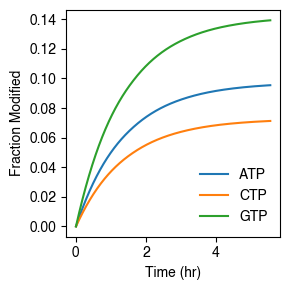

In [15]:
# Create simulated time-course data
fig, ax = plt.subplots(figsize=(3, 3))
simulate_fraction_modified(1e-6, lnkadd_atp20, lnkdeg20, 'ATP', ax)
simulate_fraction_modified(1e-6, lnkadd_ctp20, lnkdeg20, 'CTP', ax)
simulate_fraction_modified(1e-6, lnkadd_gtp20, lnkdeg20, 'GTP', ax)
plt.legend(frameon = False)
plt.tight_layout()
plt.savefig('nmr_ntp_adduction_simulation.pdf')